In [1]:
import numpy as np
import fermion as f
import matplotlib.pyplot as plt
from pandas import DataFrame
from fermion import Math as fm
from pfapack import pfaffian as pfa

from timeit import default_timer as timer

In [2]:
n=6

In [3]:
dq = f.Operator.double_quantum(n)
Z = f.Operator.global_Z(n)
time_evo = f.Unitary(dq,.05, 2.05)
Zt = [time_evo.evolve_op(Z,t) for t in time_evo.t]

In [4]:
p = f.PauliString(["Z", "Z"], [0,2], [True, False])
print(p)

Z0(t)Z2


In [5]:
m_str = f.MajoranaString.from_pauli_string(p)
print(m_str)

(-4+0j) * A0(t)B0(t)A2B2


C:\Users\awsta\Documents\workspace\tqd-env\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


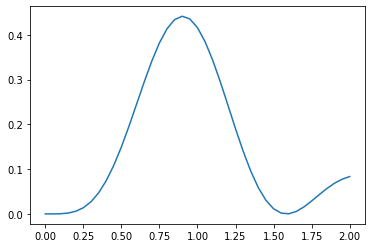

In [6]:
plt.plot(time_evo.t, time_evo.pauli_string_expectation(p))

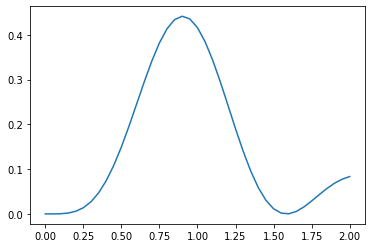

In [7]:
plt.plot(time_evo.t, time_evo.local_zz(0,2))

In [8]:
p = f.PauliString(["Z", "Z", "Z", "Z"], [0,2,0,2], [True, False, True, False])
print(p)

Z0(t)Z2Z0(t)Z2


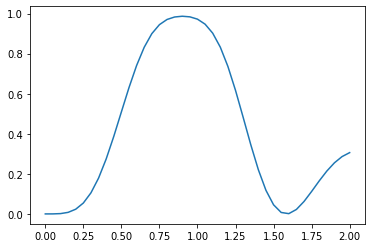

In [9]:
signal = [1-np.real(val) for val in time_evo.pauli_string_expectation(p)]
plt.plot(time_evo.t, signal)

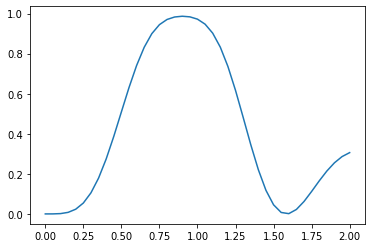

In [10]:
Z0 = f.Operator.local_Z(0,n)
Z2 = f.Operator.local_Z(2,n)
Z0t = [time_evo.evolve_op(Z0,t) for t in time_evo.t]
comm_loc = [-0.5*Z0t[i].commutator(Z2).square_trace() for i in range(len(Zt))]
plt.plot(time_evo.t, comm_loc)

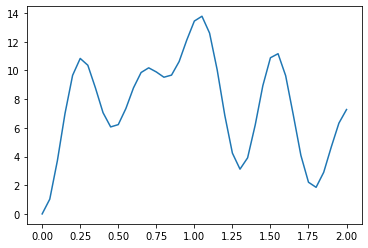

In [11]:
comm2 = [-Zt[i].commutator(Z).square_trace() for i in range(len(Zt))]
signal = [comm2[i]/Z.n_fermion for i in range(len(Zt))]
plt.plot(time_evo.t, signal)

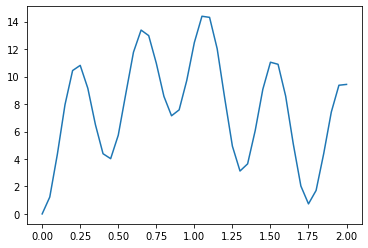

In [12]:
sig_alt = time_evo.global_OTOC("Z", "Z")
plt.plot(time_evo.t, sig_alt)

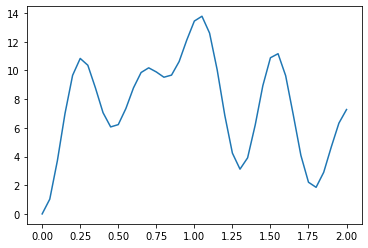

In [13]:
plt.plot(time_evo.t, time_evo.global_OTOC("Z","Z", use_true=True))

In [ ]:
# This is a verification loop which takes a long time to run
for a in range(n):
    for b in range(n):
        for c in range(n):
            for d in range(n):
                new = f.PauliString(["Z", "Z", "Z", "Z"], [a,b,c,d], [True, False, True, False])
                signal_new = [val for val in time_evo.pauli_string_expectation(new)]
                other = f.PauliString(["Z", "Z", "Z", "Z"], [b,c,a,d], [False, True, True, False])
                signal_other = [val for val in time_evo.pauli_string_expectation(other)]

                sig_dif = [-2*(new-other) for new,other in zip(signal_new, signal_other)]

                Z1 = f.Operator.local_Z(a,n)
                Z2 = f.Operator.local_Z(b,n)
                Z3 = f.Operator.local_Z(c,n)
                Z4 = f.Operator.local_Z(d,n)
                Z1t = [time_evo.evolve_op(Z1,t) for t in time_evo.t]
                Z3t = [time_evo.evolve_op(Z3,t) for t in time_evo.t]
                comm_uloc = [-1*Z1t[i].commutator(Z2).prod_trace(Z3t[i].commutator(Z4)) for i in range(len(Zt))]

                if not np.allclose(sig_dif, comm_uloc):
                    print(str(a)+str(b)+str(c)+str(d))


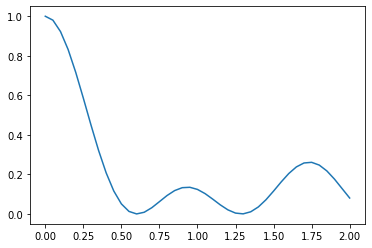

In [14]:
a,b=2,2
p = f.PauliString(["Z","Z"],[a,b],[True, False])
plt.plot(time_evo.t, time_evo.pauli_string_expectation(p))

In [15]:
zz_corr = np.zeros(len(time_evo.t))
for a in range(n):
    for b in range(n):
        p = f.PauliString(["Z","Z"],[a,b],[True, False])
        zz_corr = [prev+cur for prev,cur in zip(zz_corr, time_evo.pauli_string_expectation(p))]

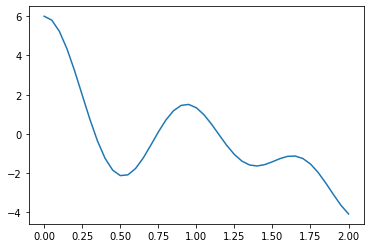

In [16]:
plt.plot(time_evo.t, zz_corr)

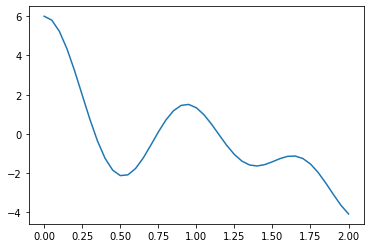

In [17]:
plt.plot(time_evo.t, time_evo.global_zz())

In [ ]:
def pfaffian_helper(pauli_string, t):
        r"""
        Actually do the numerical work of computing the reduced 2-body correlation matrix and
        taking its pfaffian to compute the pauli string expectation value.
        """
        # transform pauli string into majorana fermion representation
        maj_str = f.MajoranaString.from_pauli_string(pauli_string)

        n = len(maj_str)
        if n % 2 == 1:
            return 0

        # compute all 2-body majorana expectation values ahead of time
        corr = time_evo.majorana_two_body(t)

        # generate the skew-symmetric matrix encoding the total expecation value to be
        # extracted via pfaffian
        pf_mat = np.zeros((n, n), dtype=np.complex128)
        for i in range(n):
            for j in range(i + 1, n):
                idx1 = maj_str.sites[i] + time_evo.n_fermion * int(
                    maj_str.majoranas[i] == "B"
                )
                idx2 = maj_str.sites[j] + time_evo.n_fermion * int(
                    maj_str.majoranas[j] == "B"
                )

                if maj_str.evo_bools[i] == maj_str.evo_bools[j]:
                    # Case where both operators are evolved or neither are evolved (static case)
                    pf_mat[i, j] = 0.5 * int(idx1 == idx2)
                else:
                    # case where one only one operator is evolved (dynamic case)
                    if maj_str.evo_bools[i]:
                        # subcase where the first operator is evolved
                        pf_mat[i, j] = corr[idx1, idx2]
                    else:
                        # subcase where the second operator is evolved
                        pre = 1
                        if (idx1 < time_evo.n_fermion and idx2 >= time_evo.n_fermion) or (
                            idx1 >= time_evo.n_fermion and idx2 < time_evo.n_fermion
                        ):
                            # fix ordering phase for upper right and lower left blocks
                            pre = -1
                        pf_mat[i, j] = pre * corr[idx1, idx2]

        # anti-symmetrize
        pf_mat = pf_mat - pf_mat.transpose()
        return maj_str.pre_factor, pf_mat

In [ ]:
pre, mat = pfaffian_helper(p,0)

In [ ]:
pre

In [ ]:
DataFrame(mat)

In [ ]:
pfa.pfaffian(mat)

In [ ]:
test = f.PauliString(["Z","Z"],[2,2],[False,False])

In [ ]:
pre, mat = pfaffian_helper(test,0)

In [ ]:
pre

In [ ]:
mat

In [ ]:
DataFrame(np.real(time_evo.majorana_two_body(0)))